In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 20 19:29:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!unzip "/content/drive/MyDrive/Colab/BigDataProject/BirdSpecies20-Dataset-4000.zip"

Archive:  /content/drive/MyDrive/Colab/BigDataProject/BirdSpecies20-Dataset-4000.zip
   creating: birdSpecies02/
   creating: birdSpecies02/predict/
  inflating: birdSpecies02/predict/1.jpg  
  inflating: birdSpecies02/predict/2.jpg  
  inflating: birdSpecies02/predict/3.jpg  
  inflating: birdSpecies02/predict/4.jpg  
  inflating: birdSpecies02/predict/5.jpg  
  inflating: birdSpecies02/predict/6.jpg  
   creating: birdSpecies02/test/
   creating: birdSpecies02/test/ABBOTTS BABBLER/
  inflating: birdSpecies02/test/ABBOTTS BABBLER/1.jpg  
  inflating: birdSpecies02/test/ABBOTTS BABBLER/2.jpg  
  inflating: birdSpecies02/test/ABBOTTS BABBLER/3.jpg  
  inflating: birdSpecies02/test/ABBOTTS BABBLER/4.jpg  
  inflating: birdSpecies02/test/ABBOTTS BABBLER/5.jpg  
   creating: birdSpecies02/test/ABBOTTS BOOBY/
  inflating: birdSpecies02/test/ABBOTTS BOOBY/1.jpg  
  inflating: birdSpecies02/test/ABBOTTS BOOBY/2.jpg  
  inflating: birdSpecies02/test/ABBOTTS BOOBY/3.jpg  
  inflating: birdSpeci

In [ ]:
train_dir = '/content/birdSpecies02/train'
test_dir = '/content/birdSpecies02/test'
val_dir = '/content/birdSpecies02/valid'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
class_names = sorted(os.listdir(train_dir))
print("Class names:", class_names)

Class names: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=16,
    target_size=(224, 224),
    color_mode = 'rgb',
    class_mode="sparse",
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=16,
    target_size=(224, 224),
    color_mode = 'rgb',
    class_mode="sparse"
)

val_generator = valid_datagen.flow_from_directory(
    directory=val_dir,
    batch_size=16,
    target_size=(224, 224),
    color_mode = 'rgb',
    class_mode="sparse"
)

Found 4001 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


In [ ]:
train_generator.class_indices

{'ABBOTTS BABBLER': 0,
 'ABBOTTS BOOBY': 1,
 'ABYSSINIAN GROUND HORNBILL': 2,
 'AFRICAN CROWNED CRANE': 3,
 'AFRICAN EMERALD CUCKOO': 4,
 'AFRICAN FIREFINCH': 5,
 'AFRICAN OYSTER CATCHER': 6,
 'AFRICAN PIED HORNBILL': 7,
 'AFRICAN PYGMY GOOSE': 8,
 'ALBATROSS': 9,
 'ALBERTS TOWHEE': 10,
 'ALEXANDRINE PARAKEET': 11,
 'ALPINE CHOUGH': 12,
 'ALTAMIRA YELLOWTHROAT': 13,
 'AMERICAN AVOCET': 14,
 'AMERICAN BITTERN': 15,
 'AMERICAN COOT': 16,
 'AMERICAN FLAMINGO': 17,
 'AMERICAN GOLDFINCH': 18,
 'AMERICAN KESTREL': 19}

Transfer Learning Using RESNET101V2

In [ ]:
from keras.applications import ResNet101V2
convlayer=ResNet101V2(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in convlayer.layers:
    layer.trainable=False

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
model=Sequential()
model.add(convlayer)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(20,activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (Batch  (None, 100352)            401408    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              205522944 
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                       

In [ ]:
opt=tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=125,
    epochs=20,
    validation_data=val_generator,
    validation_steps=4,
)

Epoch 1/20
125/125 [==============================] - 53s 325ms/step - loss: 1.1483 - accuracy: 0.6745 - val_loss: 0.3718 - val_accuracy: 0.8438
Epoch 2/20
125/125 [==============================] - 36s 283ms/step - loss: 0.5617 - accuracy: 0.8332 - val_loss: 0.2246 - val_accuracy: 0.9531
Epoch 3/20
125/125 [==============================] - 36s 291ms/step - loss: 0.5302 - accuracy: 0.8363 - val_loss: 0.2421 - val_accuracy: 0.9531
Epoch 4/20
125/125 [==============================] - 37s 291ms/step - loss: 0.4267 - accuracy: 0.8705 - val_loss: 0.1354 - val_accuracy: 0.9688
Epoch 5/20
125/125 [==============================] - 35s 282ms/step - loss: 0.3537 - accuracy: 0.8826 - val_loss: 0.2140 - val_accuracy: 0.9062
Epoch 6/20
125/125 [==============================] - 36s 285ms/step - loss: 0.3851 - accuracy: 0.8781 - val_loss: 0.0424 - val_accuracy: 0.9688
Epoch 7/20
125/125 [==============================] - 36s 289ms/step - loss: 0.3843 - accuracy: 0.8820 - val_loss: 0.2002 - val_ac

In [ ]:
model.save('/content/drive/MyDrive/Colab/BigDataProject/savedModels/bird-species-Resnet101V2-with-data-augumentation-version02-Day02.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


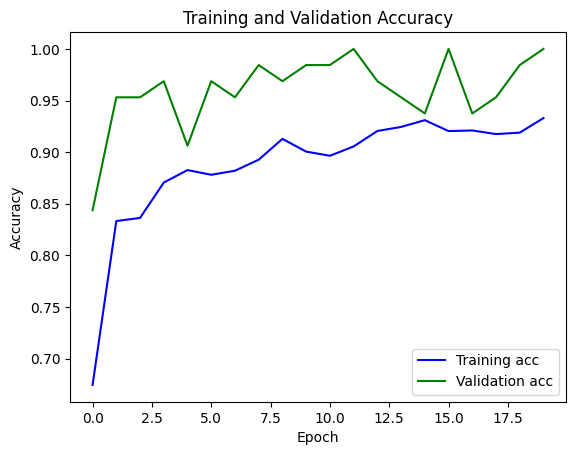

In [ ]:
plt.plot(history.history['accuracy'],c='blue')
plt.plot(history.history['val_accuracy'],c='green')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training acc','Validation acc'],loc='lower right')

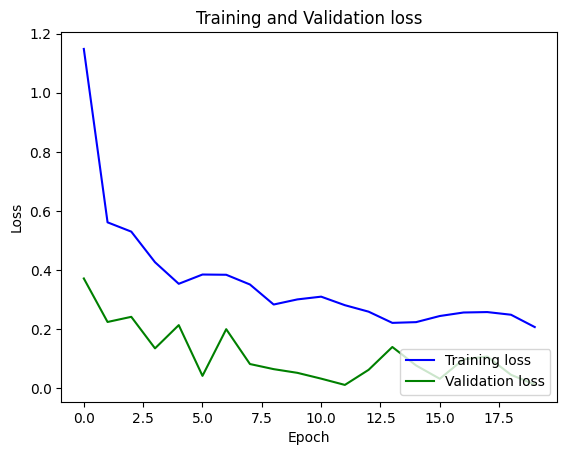

In [ ]:
plt.plot(history.history['loss'],c='blue')
plt.plot(history.history['val_loss'],c='green')
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss','Validation loss'],loc='lower right')

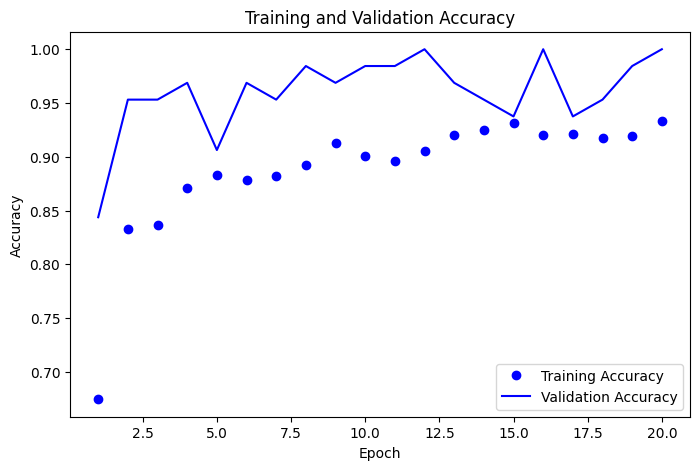

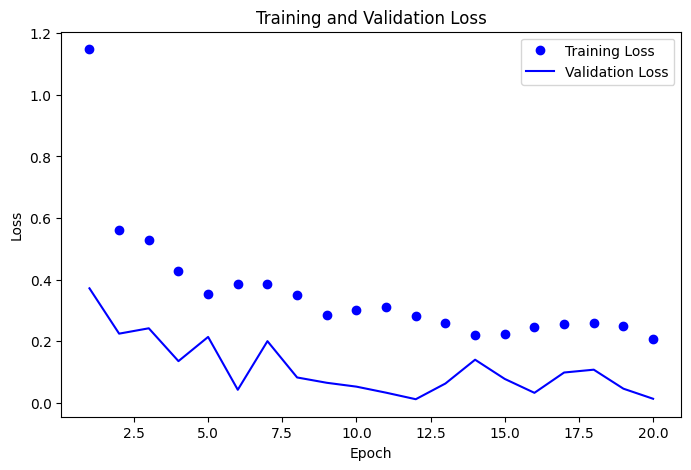

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

7/7 [==============================] - 2s 260ms/step - loss: 0.0540 - accuracy: 0.9900
Test Loss: 0.053984299302101135
Test Accuracy: 0.9900000095367432
Test accuracy: 99.00%
